# Gibbs sampling on random multivariate Gaussians.

In [3]:
from copy import copy
from functools import partial
import numpy as np
import pylab as plt
import scipy.stats as scs
from scipy.interpolate import griddata

# Plotting functions.

In [4]:
def get_mesh_bounds(models, num_sigma=3):
    covs = [model.cov for model in models]
    # For three std away.
    return np.sqrt(np.max(covs)) * num_sigma

def get_mesh_xy_and_positions(models, res=.01, num_sigma=3, plot_bounds=None):
    if plot_bounds is not None:
        mesh_lb, mesh_ub = plot_bounds
    else:
        mesh_ub = get_mesh_bounds(models, num_sigma=num_sigma) + res
        mesh_lb = - mesh_ub 
    x, y = np.mgrid[mesh_lb:mesh_ub:res, mesh_lb:mesh_ub:res]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return x, y, pos

def plot_contours2d(models, ax=None, alpha=0.3, plot_bounds=None):
    assert len(models[0].mean) == 2
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    if plot_bounds is not None:
        x, y, pos = get_mesh_xy_and_positions(models, plot_bounds=plot_bounds)
    else:
        x, y, pos = get_mesh_xy_and_positions(models, num_sigma=3)
                                            
    levels = [0.01]# + list(np.arange(0.2, 1.2, 0.1))
    cmap = ['viridis', 'cool', 'hot']
    for i, model in enumerate(models):
        #levels = [ model.pdf(point) for point in points ]
        ax.contour(x, y, model.pdf(pos), levels, cmap=cmap[i % len(cmap)], label='model %d' % i,
                   alpha=alpha)
        ax.hold(True)
    ax.set_aspect('equal')#, 'datalim')
    ax.tick_params(labelsize='xx-small')
    #ax.set_xbound(bounds[0], bounds[1])
    #ax.set_ybound(bounds[0], bounds[1])
    #ax.legend()
    #plt.colorbar(ax)
    bounds = [np.min(x), np.max(x)]
    return ax, bounds

def plot_samples(ax, samples, alpha=0.01, s=2, plot_bounds=(-4, 4), 
                 title_str=None):
    #ax.autoscale(False) # To avoid that the scatter changes limits
    samples = np.asarray(samples)
    ax.scatter(samples[:, 0], samples[:, 1], s=s, zorder=1, alpha=alpha)
    ax.set_aspect('equal')
    if title_str is not None:
        ax.set_title(title_str, fontsize='xx-small')
    ax.tick_params(labelsize='xx-small')
    ax.set_xbound(plot_bounds[0], plot_bounds[1])
    ax.set_ybound(plot_bounds[0], plot_bounds[1])
    return ax, plot_bounds

# Make model functions.

In [31]:
# Make random covariances using the wishart distribution
def make_random_models(num_models=2, ndim=2, df=2, high_cov_prior=False):
    means = [[0,0]] * num_models
    scale = np.diag([5, 0.1])
    scale = np.array([[1, 0.9], [0.9, 1]])
    if not high_cov_prior:
        covs = scs.wishart.rvs(df=df, scale=1./df * np.eye(ndim), 
                               size=num_models)
    else:
        covs_0 = scs.wishart.rvs(df=df, scale=1./df * scale, 
                                 size=2)
        scale = np.array([[1, -0.8], [-0.8, 1]])
        covs_1 = scs.wishart.rvs(df=df, scale=1./df * scale, 
                                 size=2)
        covs = np.concatenate((covs_0[:1], covs_1[:1]), axis=0)
    #print covs
    return [scs.multivariate_normal(mean, cov)
            for mean, cov in zip(means, covs)]
    # np.concatenate((covs, covs_1), 0)

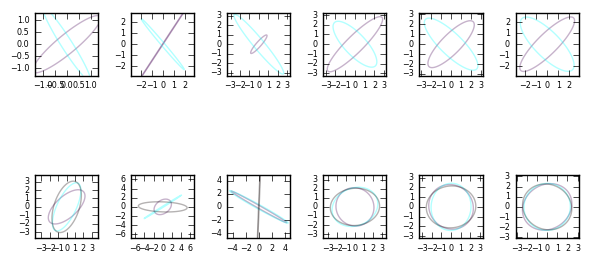

In [28]:
# Explore the different parameters on wishart. 
ntrials = 3
fig, axes = plt.subplots(2, ntrials*2)
for j, high_cov_prior in enumerate([True, False]):
    for i in range(ntrials):
        for k, df in enumerate([2, 100]):
            models = make_random_models(num_models=3, high_cov_prior=high_cov_prior, df=df)
            _, bounds = plot_contours2d(models, axes[j, k*ntrials + i])
plt.tight_layout()
plt.show()

In [7]:
n = 10000
mat = scs.wishart.rvs(n, 1./n*np.eye(3))
np.linalg.svd(mat)

(array([[-0.24640134, -0.00687455, -0.9691435 ],
        [-0.09881376,  0.99494195,  0.0180655 ],
        [ 0.96411733,  0.10021608, -0.24583433]]),
 array([ 1.0144972 ,  1.00153422,  0.96774251]),
 array([[-0.24640134, -0.09881376,  0.96411733],
        [-0.00687455,  0.99494195,  0.10021608],
        [-0.9691435 ,  0.0180655 , -0.24583433]]))

# Compute conditionals

In [8]:
def compute_cond_moments(model, cond_val=None, cond_ax=None):
    # assumes two dimensional for now.
    assert len(model.mean) == 2
    # [x, y]T ~ N([a, b]T, [[A, C], [CT, B]]) 
    # => x|y ~ N(a + C B-1 (y-b), A - C B-1 CT)
    pred_ax = abs(1 - cond_ax)
    C = model.cov[1, 0]
    B = model.cov[cond_ax, cond_ax]
    mean = model.mean[pred_ax] + C * 1./B * (cond_val-model.mean[cond_ax])
    cov = model.cov[pred_ax, pred_ax] - C * 1./B * C 
    #print mean, cov, 'conditioned on cond_ax=%d, cond_val=%.2f' % (cond_ax, cond_val)
    return mean, cov
def get_cond_norm(model, **kwargs):
    mean, cov = compute_cond_moments(model, **kwargs)
    return multivariate_normal(mean, cov)
def sample_cond_norm(model, **kwargs):
    mean, cov = compute_cond_moments(model, **kwargs)
    return scs.multivariate_normal.rvs(mean, cov)

In [9]:
np.linalg.solve?

# Mixture, product of Gaussians

In [79]:
def sample_mixture_gaussian(ax, models, nsamples=1000, plot_bounds=None):
    samples = []
    for i in range(nsamples):
        # Randomly chose model.
        model_idx = np.random.choice(len(models), size=1)[0]
        model = models[model_idx]
        sample = scs.multivariate_normal.rvs(model.mean, model.cov)
        samples.append(sample)
    samples = np.asarray(samples)
    plot_samples(ax, samples)
    ax.set_title('mixture of Gauss', fontsize='small')
    ax.tick_params(labelsize='small')
    if plot_bounds is not None:
        for fn in [ax.set_xbound, ax.set_ybound]:
            fn(plot_bounds[0], plot_bounds[1])
    return samples

In [ ]:
# Check the mixture of Gaussians.
ntrials = 3
fig, axes = plt.subplots(1, ntrials)
#axes = np.ravel(axes)
for i in range(ntrials):
    models = make_random_models(num_models=3)
    ax, ref_plt_bds = plot_contours2d(models, axes[i])
    samples = sample_mixture_gaussian(ax, models, nsamples=5000, plot_bounds=ref_plt_bds)
plt.show()

In [32]:
# Product of gaussians, ref roweis's notes on gaussid
def gauss_prod(models):
    print '# of models', len(models)
    mean = models[0].mean
    C = models[0].cov
    c = models[0].mean
    inv = np.linalg.inv
    for model in models[1:]:
        # update
        B = C
        b = c
        #print b, B
        A = model.cov
        a = model.mean
        C = inv(inv(A) + inv(B))
        c = (np.dot(np.dot(C, inv(A)), a) + 
             np.dot(np.dot(C, inv(B)), b))
    return scs.multivariate_normal(c, C)

# of models 2
# of models 3


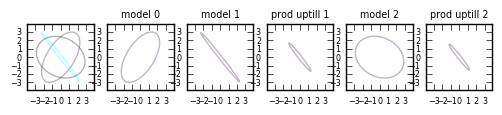

In [33]:
# Check: iteratively add models and check how the product updates.
num_models = 3
fig, axes = plt.subplots(1, num_models*2)
axes = np.ravel(axes)
models = make_random_models(num_models=num_models)
ax, ref_plt_bds = plot_contours2d(models, axes[0])
ax, _ = plot_contours2d([models[0]], axes[1], plot_bounds=ref_plt_bds)
ax.set_title('model 0', fontsize='x-small')
for i in range(1, num_models):
    ax, _ = plot_contours2d([models[i]], axes[i*2], plot_bounds=ref_plt_bds)
    ax.set_title('model %d' % i, fontsize='x-small')
    prod = gauss_prod(models[:(i+1)])
    ax, _ = plot_contours2d([prod], axes[i*2 + 1], plot_bounds=ref_plt_bds)
    ax.set_title('prod uptill %d' % i, fontsize='x-small')
plt.show()

# of models 3
# of models 3
# of models 3


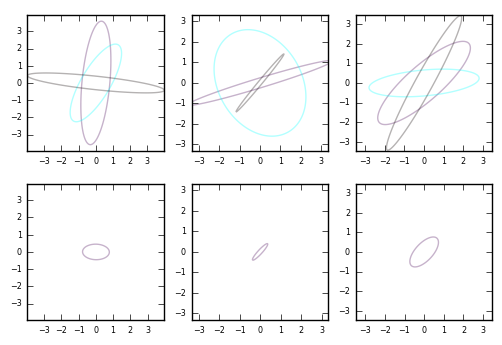

In [34]:
# Check the product of different sets of random Gaussians.
ntrials = 3
fig, axes = plt.subplots(2, ntrials)
#axes = np.ravel(axes)
for i in range(ntrials):
    models = make_random_models(num_models=3)
    ax, plot_bounds = plot_contours2d(models, axes[0, i])
    prod = gauss_prod(models)
    ax, plot_bounds = plot_contours2d([prod], axes[1, i], 
                                      plot_bounds=plot_bounds)

plt.show()

# Gibbs sampling

In [68]:
def random_pick(models=models, **kwargs):
    rand_ind = np.random.randint(len(models))
    return models[rand_ind]

def fixed_scan_0(models=models, previous_model=None, **kwargs):
    if previous_model is None:
        model_idx = 0
    else:
        model_idx = models.index(previous_model) + 1
    return models[model_idx % len(models)]

def fixed_scan_1(models=models, previous_model=None, **kwargs):
    if previous_model is None:
        model_idx = 1
    else:
        model_idx = models.index(previous_model) + 1
    return models[model_idx % len(models)]

def run_gibbs(ax, models, model_pick_fn, init_val=None, 
              nsamples=5000, nburnin=1000, plot_bounds=None):
    # Plot background
    ax, plot_bounds = plot_contours2d(models, ax, plot_bounds=plot_bounds)
    # Initialization
    ndim = models[0].mean.size
    init_val = np.random.random(ndim)
    cond_ax = np.random.randint(ndim)
    title_str = 'init='
    for val in init_val:
        title_str += '%.2f, ' % val
    samples = [init_val]
    niters = nsamples + nburnin
    model = None
    for i in range(niters):
        if i % 5000 == 0:
            print 'sample', i,
        cur_sample = samples[-1].copy()
        model = model_pick_fn(models=models, previous_model=model)
        #print 'model idx', models.index(model)
        sampled_ax = np.random.randint(ndim)
        assert ndim == 2
        cond_ax = 1 if sampled_ax == 0 else 0
        assert cond_ax != sampled_ax
        cond_val = cur_sample[cond_ax]
        sampled_val = sample_cond_norm(model, cond_val=cond_val, 
                                       cond_ax=cond_ax)
        cur_sample[sampled_ax] = sampled_val
        samples.append(cur_sample)
        
    samples = np.asarray(samples)
    samples = samples[nburnin:]
    #print samples.shape
    plot_samples(ax, samples, plot_bounds=plot_bounds)
    ax.set_aspect('equal')
    ax.set_title(title_str, fontsize='small')
    ax.tick_params(labelsize='small')
    for fn in [ax.set_xbound, ax.set_ybound]:
        fn(plot_bounds[0], plot_bounds[1])

In [69]:
def run_gibbs_job(ntrails=1, num_models=3, nsamples=5000, nburnin=1000, trial_models=None):
    # - ensemble (showing individual experts)
    # - product 
    # - sampled product
    # - Gibbs (random-scan)
    # - Gibbs fixed-scan
    # - Gibbs fixed-scan (another ordering)
    # - mixture samples
    
    fig, axes = plt.subplots(7, ntrials, figsize=(12,12))
    #if trial_models is not None:
    #    num_models = len(trial_models)
    #axes = np.ravel(axes)
    if trial_models is None:
        trial_models = [make_random_models(num_models=num_models) for i in range(ntrails)]
    for i in range(ntrials):
        models = trial_models[i]
        ax, ref_plt_bds = plot_contours2d(models, axes[0, i])

        # plot product of Gaussians
        prod = gauss_prod(models)
        ax, _ = plot_contours2d([prod], axes[1, i], plot_bounds=ref_plt_bds)
        samples = scs.multivariate_normal.rvs(prod.mean, prod.cov, 
                                              size=nsamples)
        print '# of samples', samples.shape
        ax, _ = plot_samples(samples=samples, ax=axes[2, i], plot_bounds=ref_plt_bds)

        # plot gibbs samples
        run_gibbs(axes[3, i], models=models, model_pick_fn=random_pick,
                  nsamples=nsamples, nburnin=nburnin)
        
        # fixed scan
        run_gibbs(axes[4, i], models=models, model_pick_fn=fixed_scan_0,
                  nsamples=nsamples, nburnin=nburnin)
        
        # fixed scan
        run_gibbs(axes[5, i], models=models, model_pick_fn=fixed_scan_1,
                  nsamples=nsamples, nburnin=nburnin)
        
        # Samples from mixture
        ax, _ = plot_contours2d(models, axes[6, i], plot_bounds=ref_plt_bds)
        samples = sample_mixture_gaussian(ax=ax, models=models, nsamples=nsamples, plot_bounds=ref_plt_bds)
        
    plt.tight_layout()
    plt.show()
    return trial_models

# of models 3
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000 # of models 3
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000 # of models 3
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000

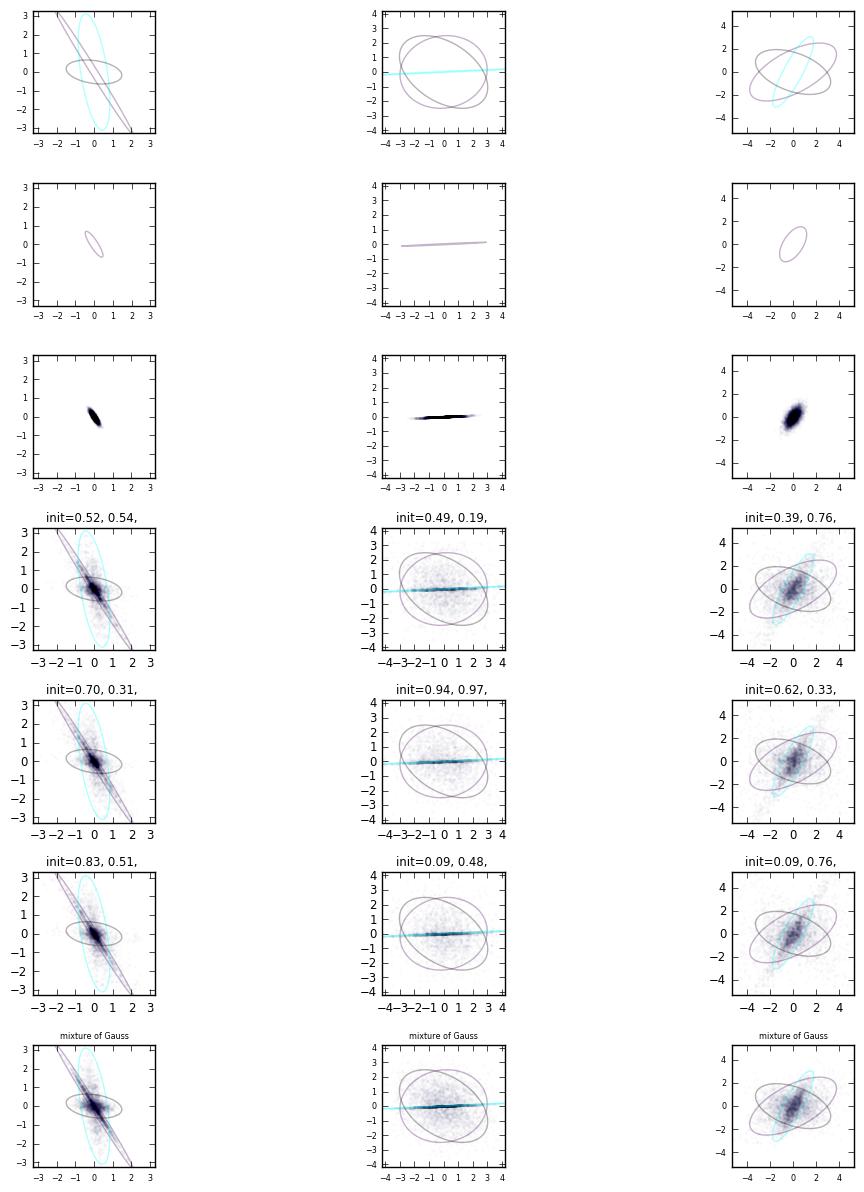

In [77]:
ntrails = 3
trial_models = [make_random_models(num_models=num_models) for i in range(ntrails)]
trial_models = run_gibbs_job(trial_models=trial_models)

# of models 2
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000 # of models 2
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000 # of models 2
# of samples (5000, 2)
sample 0 sample 5000 sample 0 sample 5000 sample 0 sample 5000

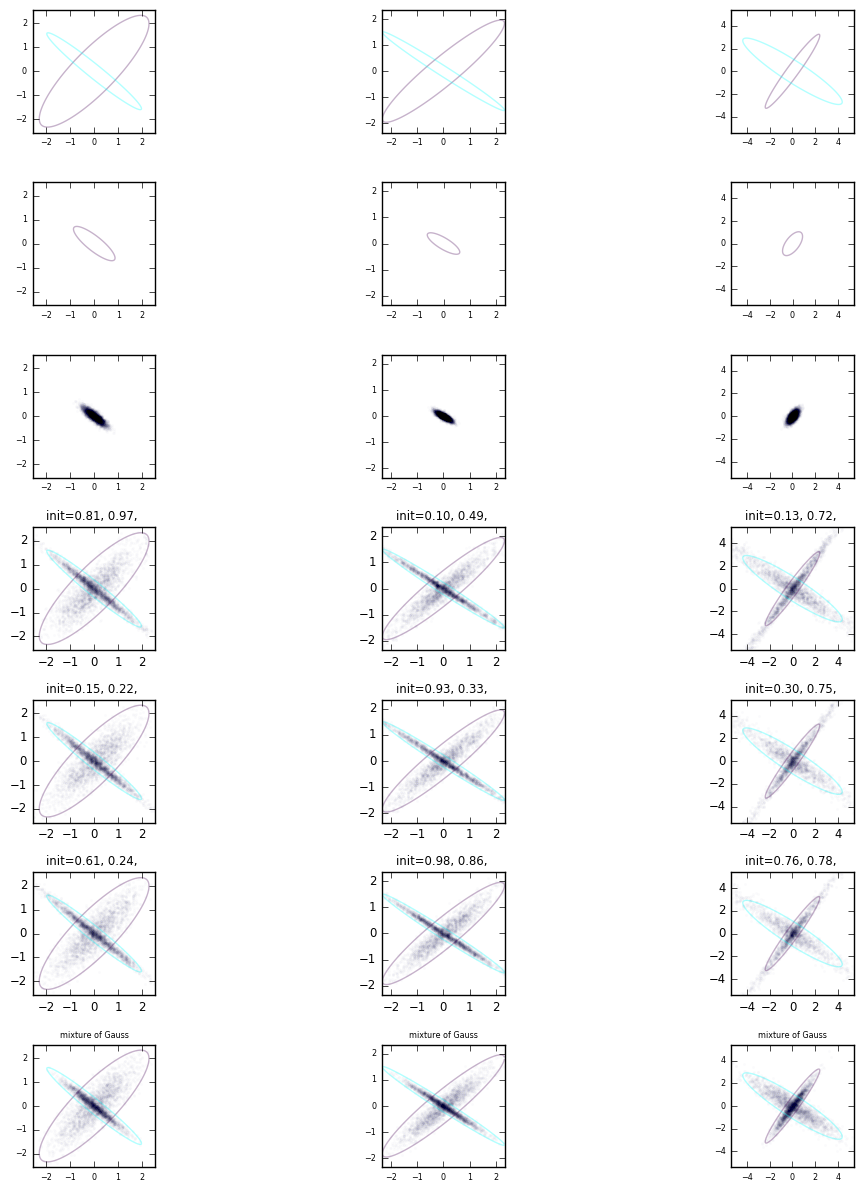

In [76]:
ntrails = 3
trial_models = [make_random_models(num_models=num_models, high_cov_prior=True) for i in range(ntrails)]
trial_models = run_gibbs_job(trial_models=trial_models)